In [3]:
# %pip install --force-reinstall pandas numpy torch torchvision torchaudio scikit-learn tqdm scikit-learn transformers nltk matplotlib
# %pip install --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install --force-reinstall gensim

In [12]:
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
diagnoses = notes = pd.read_csv('mimiciii_data/DIAGNOSES_ICD.csv.gz', compression='gzip')
admissions = notes = pd.read_csv('mimiciii_data/ADMISSIONS.csv.gz', compression='gzip')
notes = pd.read_csv('mimiciii_data/NOTEEVENTS.csv.gz', compression='gzip')
disch_notes = notes[notes['CATEGORY'] == 'Discharge summary']
disch_notes = disch_notes.sort_values(by='CHARTDATE').groupby('HADM_ID')['TEXT'].last().reset_index()

diag_codes = diagnoses.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()

C:\Users\Taqvi\AppData\Local\Temp\ipykernel_2392\1698704895.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv('mimiciii_data/NOTEEVENTS.csv.gz', compression='gzip')


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[\*\*.*?\*\*\]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

disch_notes['TEXT'] = disch_notes['TEXT'].apply(clean_text)

In [8]:
merged = pd.merge(disch_notes, diag_codes, on='HADM_ID')
merged = merged.dropna(subset=['TEXT', 'ICD9_CODE'])
merged['ICD9_CODE'] = merged['ICD9_CODE'].apply(lambda codes: [str(code) for code in codes])

Coverage for top 1 codes: 38.02%
Coverage for top 10 codes: 76.93%
Coverage for top 100 codes: 96.02%
Coverage for top 1000 codes: 99.70%


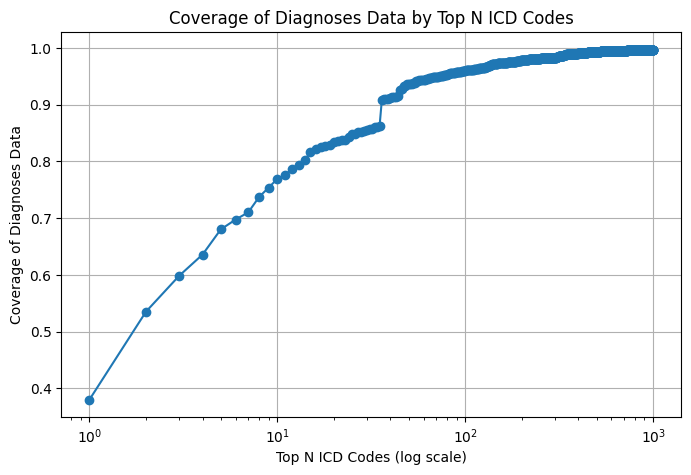

In [9]:
def plot_top_n_coverage(df, n=1000):
    df = df.dropna(subset=['ICD9_CODE'])
    df['ICD9_CODE'] = df['ICD9_CODE'].apply(lambda codes: [str(code) for code in codes] if isinstance(codes, (list, tuple)) else [str(codes)])
    all_codes = [code for codes in df['ICD9_CODE'] for code in codes]
    code_counts = Counter(all_codes)
    coverages = []
    pows = [10**i for i in range(int(np.log10(n))+1) if 10**i <= n]
    for k in range(1, n+1):
        current_top = [code for code, _ in code_counts.most_common(k)]
        cov = df['ICD9_CODE'].apply(lambda codes: any(code in current_top for code in codes)).mean()
        coverages.append(cov)
        if (k in pows):
            print(f'Coverage for top {k} codes: {cov*100:.2f}%')
    plt.figure(figsize=(8,5))
    plt.plot(range(1, n+1), coverages, marker='o')
    plt.xscale('log')
    plt.xlabel('Top N ICD Codes (log scale)')
    plt.ylabel('Coverage of Diagnoses Data')
    plt.title('Coverage of Diagnoses Data by Top N ICD Codes')
    plt.grid(True, which='major', axis='both')
    plt.show()

plot_top_n_coverage(merged)

In [10]:
all_codes = [code for codes in merged['ICD9_CODE'] for code in codes]
top100 = set([code for code, _ in Counter(all_codes).most_common(100)])

def filter_top100(row):
    filtered = [code for code in row if code in top100]
    return filtered if filtered else None

merged['ICD9_CODE'] = merged['ICD9_CODE'].apply(filter_top100)
merged = merged.dropna(subset=['ICD9_CODE'])

In [11]:
train, temp = train_test_split(merged, test_size=0.2, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=7)
print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")

Train shape: (40500, 3), Validation shape: (5062, 3), Test shape: (5063, 3)


In [14]:
max_len = 1000
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_len, standardize=None)
vectorizer.adapt(train['TEXT'].values)
vocab = vectorizer.get_vocabulary()
mlb = MultiLabelBinarizer()
mlb.fit(train['ICD9_CODE'])
num_classes = len(mlb.classes_)
vocab_size = len(vocab)
embed_dim = 256

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Taqvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
def encode_sentence(sentence, vectorizer):
    idxs = vectorizer(np.array([sentence])).numpy()[0]
    return idxs.tolist()

In [75]:
def train_model(model, train_loader, val_loader, lr=1e-3, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    name = type(model).__name__

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        for x, y in train_iter:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            train_iter.set_postfix(loss=loss.item())
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[{name}] Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")
        model.eval()
        val_loss = 0
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        with torch.no_grad():
            for x, y in val_iter:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)
                val_iter.set_postfix(loss=loss.item())
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"[{name}] Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")

In [64]:
def get_preds_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x).cpu().numpy()
            all_preds.append(out)
            all_labels.append(y.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

def optimize_threshold(y_true, y_pred):
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.91, 0.01):
        y_bin = (y_pred >= thresh).astype(int)
        f1 = f1_score(y_true, y_bin, average='micro')
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh, best_f1

def evaluate(model, val_loader, test_loader):
    val_preds, val_labels = get_preds_and_labels(model, val_loader)
    best_thresh, best_val_f1 = optimize_threshold(val_labels, val_preds)
    print(f'Best threshold: {best_thresh:.2f}, Best val F1: {best_val_f1:.4f}')

    test_preds, test_labels = get_preds_and_labels(model, test_loader)
    test_bin = (test_preds >= best_thresh).astype(int)

    precision = precision_score(test_labels, test_bin, average='micro', zero_division=0)
    recall = recall_score(test_labels, test_bin, average='micro', zero_division=0)
    f1 = f1_score(test_labels, test_bin, average='micro', zero_division=0)

    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1: {f1:.4f}')

In [65]:
class FeedforwardBaseline(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim=128):
        super(FeedforwardBaseline, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [66]:
class NotesBaselineDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.texts = df['TEXT'].tolist()
        self.labels = mlb.transform(df['ICD9_CODE'])
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        x = encode_sentence(self.texts[idx], self.vectorizer)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.float32)

In [67]:
train_ds_base = NotesBaselineDataset(train, vectorizer)
val_ds_base = NotesBaselineDataset(val, vectorizer)
test_ds_base = NotesBaselineDataset(test, vectorizer)
train_loader_base = DataLoader(train_ds_base, batch_size=32, shuffle=True)
val_loader_base = DataLoader(val_ds_base, batch_size=32)
test_loader_base = DataLoader(test_ds_base, batch_size=32)

baseline_model = FeedforwardBaseline(vocab_size, embed_dim, num_classes)
baseline_model = baseline_model.to(device)
train_model(baseline_model, train_loader_base, val_loader_base)
evaluate(baseline_model, val_loader_base, test_loader_base)

[FeedforwardBaseline] Epoch 1, Train Loss: 0.1981


[FeedforwardBaseline] Epoch 1, Val Loss: 0.1769


[FeedforwardBaseline] Epoch 2, Train Loss: 0.1761


[FeedforwardBaseline] Epoch 2, Val Loss: 0.1700


[FeedforwardBaseline] Epoch 3, Train Loss: 0.1697


[FeedforwardBaseline] Epoch 3, Val Loss: 0.1651


[FeedforwardBaseline] Epoch 4, Train Loss: 0.1639


[FeedforwardBaseline] Epoch 4, Val Loss: 0.1606


[FeedforwardBaseline] Epoch 5, Train Loss: 0.1594


[FeedforwardBaseline] Epoch 5, Val Loss: 0.1583


[FeedforwardBaseline] Epoch 6, Train Loss: 0.1558


[FeedforwardBaseline] Epoch 6, Val Loss: 0.1563


[FeedforwardBaseline] Epoch 7, Train Loss: 0.1525


[FeedforwardBaseline] Epoch 7, Val Loss: 0.1551


[FeedforwardBaseline] Epoch 8, Train Loss: 0.1496


[FeedforwardBaseline] Epoch 8, Val Loss: 0.1538


[FeedforwardBaseline] Epoch 9, Train Loss: 0.1466


[FeedforwardBaseline] Epoch 9, Val Loss: 0.1527


[FeedforwardBaseline] Epoch 10, Train Loss: 0.1437


[FeedforwardBaseline] Epoch 10, Val Loss: 0.1519
Best threshold: 0.23, Best val F1: 0.4425
Test Precision: 0.4454
Test Recall: 0.4535
Test F1: 0.4494


In [107]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, dropout_rate=0.5):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv2d(1, 128, (5, embed_dim))
        self.pool1 = nn.MaxPool2d((5, 1))
        self.conv2 = nn.Conv2d(128, 128, (5, 1))
        self.pool2 = nn.MaxPool2d((5, 1))
        self.conv3 = nn.Conv2d(128, 128, (5, 1))
        self.pool3 = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [112]:
train_ds = NotesBaselineDataset(train, vectorizer)
val_ds = NotesBaselineDataset(val, vectorizer)
test_ds = NotesBaselineDataset(test, vectorizer)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [113]:
model = TextCNN(vocab_size, embed_dim, num_classes)
model = model.to(device)
train_model(model, train_loader, val_loader)
evaluate(model, val_loader, test_loader)

[TextCNN] Epoch 1, Train Loss: 0.2026


[TextCNN] Epoch 1, Val Loss: 0.1748


[TextCNN] Epoch 2, Train Loss: 0.1815


[TextCNN] Epoch 2, Val Loss: 0.1649


[TextCNN] Epoch 3, Train Loss: 0.1758


[TextCNN] Epoch 3, Val Loss: 0.1620


[TextCNN] Epoch 4, Train Loss: 0.1725


[TextCNN] Epoch 4, Val Loss: 0.1590


[TextCNN] Epoch 5, Train Loss: 0.1694


[TextCNN] Epoch 5, Val Loss: 0.1577


[TextCNN] Epoch 6, Train Loss: 0.1678


[TextCNN] Epoch 6, Val Loss: 0.1583


[TextCNN] Epoch 7, Train Loss: 0.1661


[TextCNN] Epoch 7, Val Loss: 0.1570


[TextCNN] Epoch 8, Train Loss: 0.1645


[TextCNN] Epoch 8, Val Loss: 0.1578


[TextCNN] Epoch 9, Train Loss: 0.1629


[TextCNN] Epoch 9, Val Loss: 0.1573


[TextCNN] Epoch 10, Train Loss: 0.1617


[TextCNN] Epoch 10, Val Loss: 0.1571
Best threshold: 0.21, Best val F1: 0.4425
Test Precision: 0.4837
Test Recall: 0.4109
Test F1: 0.4443


In [34]:
class MultiScaleTextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, dropout_rate=0.5):
        super(MultiScaleTextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv2 = nn.Conv2d(1, 64, (2, embed_dim))
        self.conv3 = nn.Conv2d(1, 64, (3, embed_dim))
        self.conv4 = nn.Conv2d(1, 64, (4, embed_dim))
        self.dropout = nn.Dropout(dropout_rate)
        self.batchnorm = nn.BatchNorm1d(192)
        self.fc = nn.Linear(192, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x2 = F.relu(self.conv2(x)).squeeze(3)
        x3 = F.relu(self.conv3(x)).squeeze(3)
        x4 = F.relu(self.conv4(x)).squeeze(3)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
        x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)
        x4 = F.max_pool1d(x4, x4.size(2)).squeeze(2)
        x_cat = torch.cat((x2, x3, x4), 1)
        x_cat = self.dropout(x_cat)
        x_cat = self.batchnorm(x_cat)
        out = self.fc(x_cat)
        out = torch.sigmoid(out)
        return out

In [36]:
cnn_model2 = MultiScaleTextCNN(vocab_size, embed_dim, num_classes)
cnn_model2 = cnn_model2.to(device)
train_model(cnn_model2, train_loader, val_loader)
evaluate(cnn_model2, val_loader, test_loader)

[MultiScaleTextCNN] Epoch 1, Train Loss: 0.2354


[MultiScaleTextCNN] Epoch 1, Val Loss: 0.1747


[MultiScaleTextCNN] Epoch 2, Train Loss: 0.1831


[MultiScaleTextCNN] Epoch 2, Val Loss: 0.1663


[MultiScaleTextCNN] Epoch 3, Train Loss: 0.1762


[MultiScaleTextCNN] Epoch 3, Val Loss: 0.1612


[MultiScaleTextCNN] Epoch 4, Train Loss: 0.1712


[MultiScaleTextCNN] Epoch 4, Val Loss: 0.1558


[MultiScaleTextCNN] Epoch 5, Train Loss: 0.1670


[MultiScaleTextCNN] Epoch 5, Val Loss: 0.1515


[MultiScaleTextCNN] Epoch 6, Train Loss: 0.1640


[MultiScaleTextCNN] Epoch 6, Val Loss: 0.1488


[MultiScaleTextCNN] Epoch 7, Train Loss: 0.1615


[MultiScaleTextCNN] Epoch 7, Val Loss: 0.1464


[MultiScaleTextCNN] Epoch 8, Train Loss: 0.1593


[MultiScaleTextCNN] Epoch 8, Val Loss: 0.1451


[MultiScaleTextCNN] Epoch 9, Train Loss: 0.1576


[MultiScaleTextCNN] Epoch 9, Val Loss: 0.1437


[MultiScaleTextCNN] Epoch 10, Train Loss: 0.1564


[MultiScaleTextCNN] Epoch 10, Val Loss: 0.1430
Best threshold: 0.21, Best val F1: 0.5044
Best threshold: 0.21, Best val F1: 0.5044
Test Precision: 0.5499
Test Recall: 0.4777
Test F1: 0.5113
Test Precision: 0.5499
Test Recall: 0.4777
Test F1: 0.5113


In [86]:
def encode_sentence_with_length(sentence, vectorizer):
    idxs = encode_sentence(sentence, vectorizer)
    length = min(len([i for i in idxs if i != 0]), len(idxs))
    return idxs, length

In [87]:
def rnn_train(model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    name = type(model).__name__

    for epoch in range(10):
        model.train()
        total_loss = 0
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        for x, y, lengths in train_iter:
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
            optimizer.zero_grad()
            out = model(x, lengths.cpu())
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            train_iter.set_postfix(loss=loss.item())
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[{name}] Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")
        model.eval()
        val_loss = 0
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        with torch.no_grad():
            for x, y, lengths in val_iter:
                x, y, lengths = x.to(device), y.to(device), lengths.to(device)
                out = model(x, lengths.cpu())
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)
                val_iter.set_postfix(loss=loss.item())
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"[{name}] Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")

In [88]:
def rnn_get_preds_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y, lengths in loader:
            x, lengths = x.to(device), lengths.to(device)
            out = model(x, lengths.cpu()).cpu().numpy()
            all_preds.append(out)
            all_labels.append(y.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

def rnn_evaluate(model, val_loader, test_loader):
    val_preds_gru, val_labels_gru = rnn_get_preds_and_labels(model, val_loader)
    best_thresh_gru, best_val_f1_gru = optimize_threshold(val_labels_gru, val_preds_gru)
    print(f'Best threshold: {best_thresh_gru:.2f}, Best val F1: {best_val_f1_gru:.4f}')

    test_preds_gru, test_labels_gru = rnn_get_preds_and_labels(model, test_loader)
    test_bin_gru = (test_preds_gru >= best_thresh_gru).astype(int)

    precision_gru = precision_score(test_labels_gru, test_bin_gru, average='micro', zero_division=0)
    recall_gru = recall_score(test_labels_gru, test_bin_gru, average='micro', zero_division=0)
    f1_gru = f1_score(test_labels_gru, test_bin_gru, average='micro', zero_division=0)

    print(f'Test Precision: {precision_gru:.4f}')
    print(f'Test Recall: {recall_gru:.4f}')
    print(f'Test F1: {f1_gru:.4f}')

In [89]:
class NotesDatasetRNN(Dataset):
    def __init__(self, df, vectorizer):
        self.texts = df['TEXT'].tolist()
        self.labels = mlb.transform(df['ICD9_CODE'])
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        x, length = encode_sentence_with_length(self.texts[idx], self.vectorizer)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.float32), length
    
def collate_fn_gru(batch):
    xs, ys, lengths = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return xs, ys, lengths

In [114]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim=128, num_layers=1, dropout_rate=0.5):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out_packed, _ = self.lstm(packed)
        out, _ = rnn_utils.pad_packed_sequence(out_packed, batch_first=True)
        out_forward = out[range(len(out)), lengths-1, :self.lstm.hidden_size]
        out_backward = out[:, 0, self.lstm.hidden_size:]
        out_cat = torch.cat([self.dropout(out_forward), self.dropout(out_backward)], dim=1)
        out = self.fc(out_cat)
        out = torch.sigmoid(out)
        return out

In [115]:
train_ds = NotesDatasetRNN(train, vectorizer)
val_ds = NotesDatasetRNN(val, vectorizer)
test_ds = NotesDatasetRNN(test, vectorizer)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn_gru)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collate_fn_gru)
test_loader = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn_gru)

In [116]:
lstm_model = TextLSTM(vocab_size, embed_dim, num_classes)
lstm_model = lstm_model.to(device)
rnn_train(lstm_model, train_loader, val_loader)
rnn_evaluate(lstm_model, val_loader, test_loader)

[TextLSTM] Epoch 1, Train Loss: 0.2035


[TextLSTM] Epoch 1, Val Loss: 0.1849


[TextLSTM] Epoch 2, Train Loss: 0.1898


[TextLSTM] Epoch 2, Val Loss: 0.1801


[TextLSTM] Epoch 3, Train Loss: 0.1835


[TextLSTM] Epoch 3, Val Loss: 0.1744


[TextLSTM] Epoch 4, Train Loss: 0.1777


[TextLSTM] Epoch 4, Val Loss: 0.1717


[TextLSTM] Epoch 5, Train Loss: 0.1739


[TextLSTM] Epoch 5, Val Loss: 0.1685


[TextLSTM] Epoch 6, Train Loss: 0.1701


[TextLSTM] Epoch 6, Val Loss: 0.1666


[TextLSTM] Epoch 7, Train Loss: 0.1665


[TextLSTM] Epoch 7, Val Loss: 0.1636


[TextLSTM] Epoch 8, Train Loss: 0.1623


[TextLSTM] Epoch 8, Val Loss: 0.1616


[TextLSTM] Epoch 9, Train Loss: 0.1587


[TextLSTM] Epoch 9, Val Loss: 0.1598


[TextLSTM] Epoch 10, Train Loss: 0.1550


[TextLSTM] Epoch 10, Val Loss: 0.1596
Best threshold: 0.20, Best val F1: 0.4123
Test Precision: 0.4215
Test Recall: 0.4180
Test F1: 0.4197


In [ ]:
class TextGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim=128, num_layers=1, dropout_rate=0.6):
        super(TextGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out_packed, _ = self.gru(packed)
        out, _ = rnn_utils.pad_packed_sequence(out_packed, batch_first=True)
        out_forward = out[range(len(out)), lengths-1, :self.gru.hidden_size]
        out_backward = out[:, 0, self.gru.hidden_size:]
        out_cat = torch.cat([self.dropout(out_forward), self.dropout(out_backward)], dim=1)
        out = self.fc(out_cat)
        out = torch.sigmoid(out)
        return out

In [98]:
gru_model = TextGRU(vocab_size, embed_dim, num_classes)
gru_model = gru_model.to(device)
rnn_train(gru_model, train_loader, val_loader)
rnn_evaluate(gru_model, val_loader, test_loader)

[TextGRU] Epoch 1, Train Loss: 0.1996


[TextGRU] Epoch 1, Val Loss: 0.1729


[TextGRU] Epoch 2, Train Loss: 0.1752


[TextGRU] Epoch 2, Val Loss: 0.1599


[TextGRU] Epoch 3, Train Loss: 0.1649


[TextGRU] Epoch 3, Val Loss: 0.1507


[TextGRU] Epoch 4, Train Loss: 0.1574


[TextGRU] Epoch 4, Val Loss: 0.1453


[TextGRU] Epoch 5, Train Loss: 0.1513


[TextGRU] Epoch 5, Val Loss: 0.1404


[TextGRU] Epoch 6, Train Loss: 0.1466


[TextGRU] Epoch 6, Val Loss: 0.1380


[TextGRU] Epoch 7, Train Loss: 0.1426


[TextGRU] Epoch 7, Val Loss: 0.1374


[TextGRU] Epoch 8, Train Loss: 0.1392


[TextGRU] Epoch 8, Val Loss: 0.1371


[TextGRU] Epoch 9, Train Loss: 0.1359


[TextGRU] Epoch 9, Val Loss: 0.1371


[TextGRU] Epoch 10, Train Loss: 0.1330


[TextGRU] Epoch 10, Val Loss: 0.1374
Best threshold: 0.24, Best val F1: 0.5250
Test Precision: 0.5591
Test Recall: 0.5087
Test F1: 0.5327


In [117]:
torch.save(baseline_model.state_dict(), 'FeedforwardBaseline.pt')
torch.save(model.state_dict(), 'TextCNN.pt')
torch.save(cnn_model2.state_dict(), 'MultiScaleTextCNN.pt')
torch.save(gru_model.state_dict(), 'TextGRU.pt')
torch.save(lstm_model.state_dict(), 'TextLSTM.pt')

In [141]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curves(model, loader, model_name="Model"):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for x, y, *_ in loader:
            x = x.to(device)
            if (model_name in ["TextLSTM", "TextGRU"]):
                lengths = (_[0]).cpu()
                probs = model(x, lengths).cpu().numpy()
            else:
                probs = model(x).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(y.numpy())
    y_true = np.vstack(all_labels)
    y_score = np.vstack(all_probs)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_true.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})', color='deeppink', linestyle='-')
    plt.plot(fpr["macro"], tpr["macro"], label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})', color='navy', linestyle='-')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

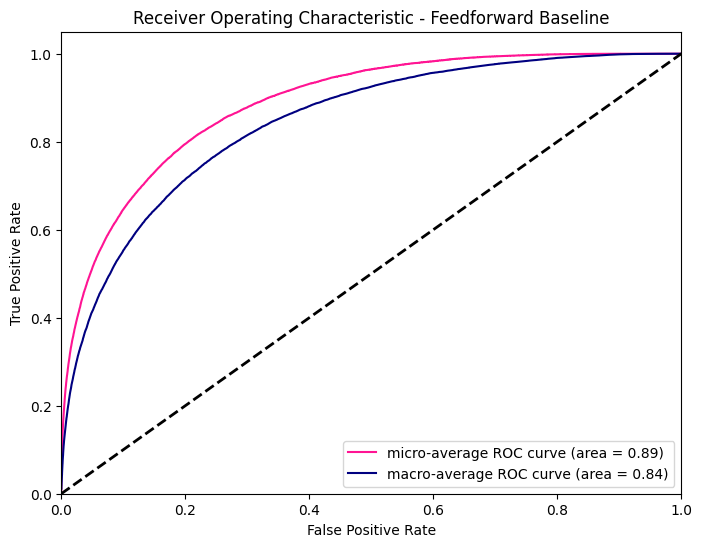

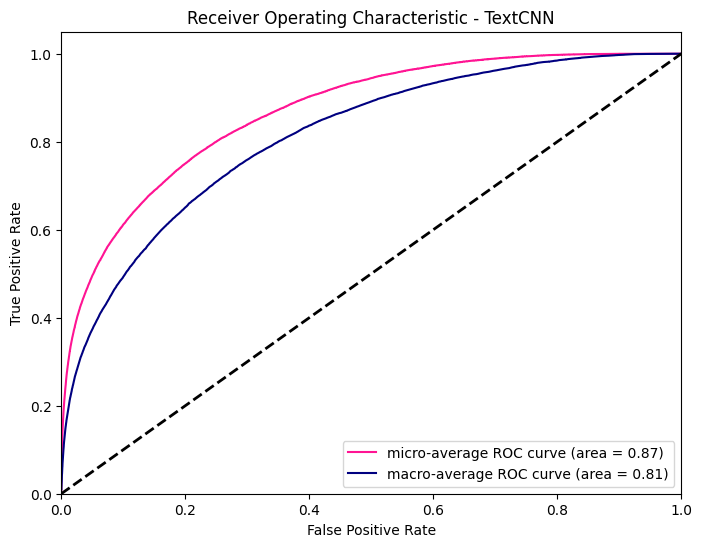

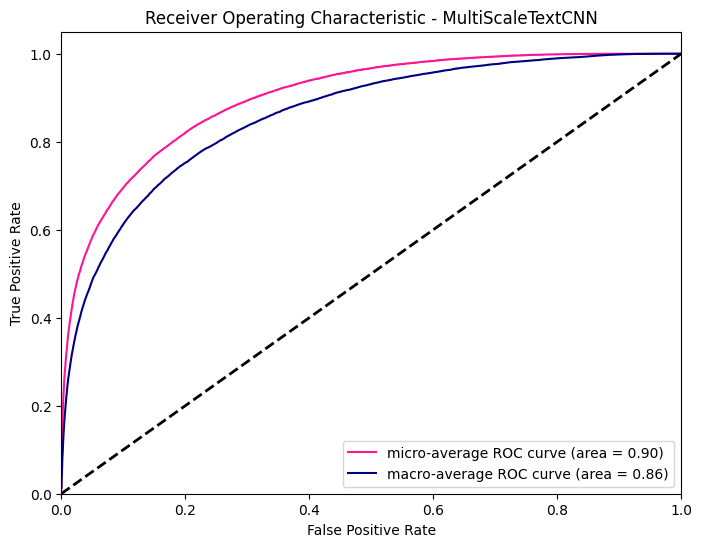

In [137]:
train_ds_base = NotesBaselineDataset(train, vectorizer)
val_ds_base = NotesBaselineDataset(val, vectorizer)
test_ds_base = NotesBaselineDataset(test, vectorizer)
train_loader_base = DataLoader(train_ds_base, batch_size=32, shuffle=True)
val_loader_base = DataLoader(val_ds_base, batch_size=32)
test_loader_base = DataLoader(test_ds_base, batch_size=32)
plot_roc_curves(baseline_model, test_loader_base, model_name="Feedforward Baseline")
plot_roc_curves(model, test_loader, model_name="TextCNN")
plot_roc_curves(cnn_model2, test_loader, model_name="MultiScaleTextCNN")


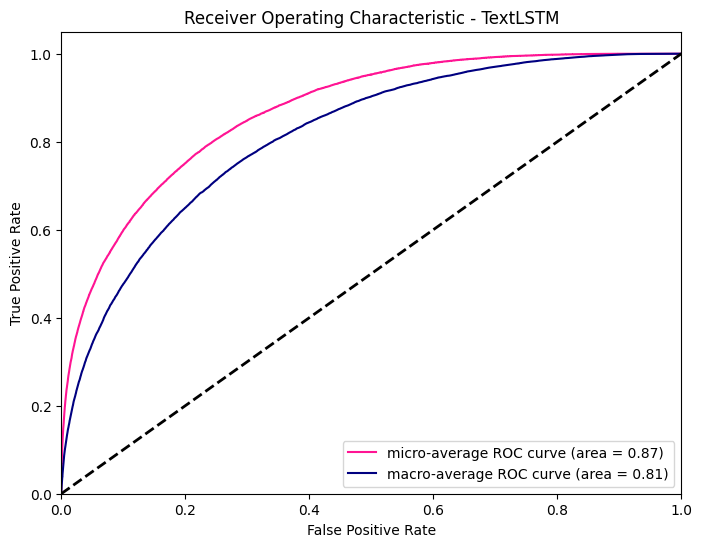

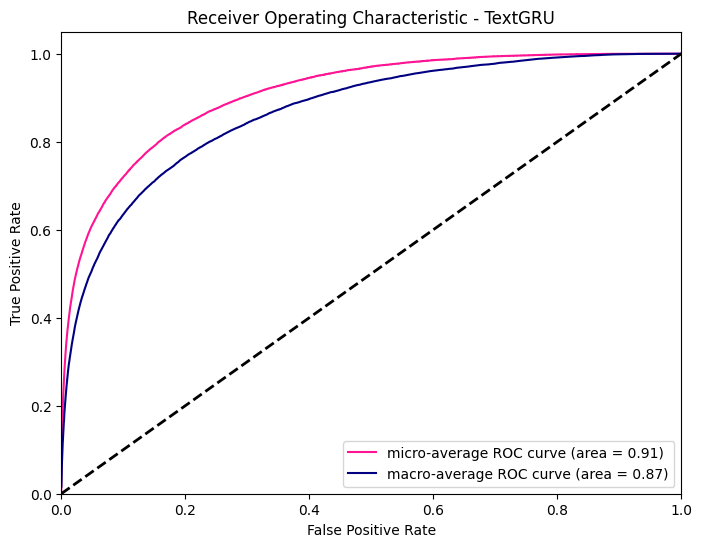

In [143]:
train_ds = NotesDatasetRNN(train, vectorizer)
val_ds = NotesDatasetRNN(val, vectorizer)
test_ds = NotesDatasetRNN(test, vectorizer)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn_gru)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collate_fn_gru)
test_loader = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn_gru)
plot_roc_curves(lstm_model, test_loader, model_name="TextLSTM")
plot_roc_curves(gru_model, test_loader, model_name="TextGRU")